In [225]:
# 모듈 로딩
import spacy
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.classification import BinaryF1Score

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [226]:
# 데이터 준비
FILE_PATH = './naver.csv'

Cartoon_DF = pd.read_csv(FILE_PATH)
# Cartoon_Chal_DF = pd.read_csv(FILE_PATH2) => age 카테고리가 없음.

In [227]:
Cartoon_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2100 non-null   int64  
 1   title        2100 non-null   object 
 2   author       2100 non-null   object 
 3   genre        2100 non-null   object 
 4   description  2100 non-null   object 
 5   rating       2100 non-null   float64
 6   date         2100 non-null   object 
 7   completed    2100 non-null   bool   
 8   age          1998 non-null   object 
 9   free         2100 non-null   bool   
 10  link         2100 non-null   object 
dtypes: bool(2), float64(1), int64(1), object(7)
memory usage: 151.9+ KB


In [228]:
Cartoon_DF['completed'] = Cartoon_DF['completed'].astype('int16')
Cartoon_DF['free'] = Cartoon_DF['free'].astype('int16')

In [229]:
Cartoon_DF = Cartoon_DF[~ Cartoon_DF['age'].isna()]

In [230]:
# 데이터 불균형이기 때문에 18세 이용가 날림
Cartoon_DF['age'].value_counts()

age
전체연령가      868
15세 이용가    578
12세 이용가    486
18세 이용가     66
Name: count, dtype: int64

In [231]:
Cartoon_DF = Cartoon_DF[~(Cartoon_DF['age'] == '18세 이용가')]

In [232]:
len(Cartoon_DF)

1932

In [233]:
## target 수치화
target = []
for num in range(len(Cartoon_DF)):
    if Cartoon_DF.iloc[num]['age'] == '전체연령가': 
        target.append(0)
    elif Cartoon_DF.iloc[num]['age'] == '12세 이용가' or Cartoon_DF.iloc[num]['age'] == '15세 이용가':
        target.append(1)
Cartoon_DF['target'] = target

In [234]:
Cartoon_DF['target'].value_counts()

target
1    1064
0     868
Name: count, dtype: int64

In [235]:
Cartoon_DF.target.values

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [236]:
import re
def re_text(text):
    text = re.sub(r'[^ㄱ-ㅎ가-힣 ]+', ' ', text)
    text = text.replace('\xa0','')
    
    return text.strip()

In [237]:
Cartoon_DF['description'] = Cartoon_DF['description'].apply(re_text)

In [238]:
Cartoon_DF['description']

0       흔하디 흔한 재벌후계자와 캔디도 울고 갈 박복한 가난소녀의 파란만장 동거기 인기작 ...
1       이번 주인공은 돌이다 돌이지만 동료도 모으고 악당도 물리친다 랑또 작가표 동양 판타...
2       어느 날  인어가 내게 말을 걸어왔다  눈을 떠보니 총구가 있었다  그리고 몸이 연...
3          한국 최초 한국형 고교스포츠 웹툰 열혈따윈 개나 줘  낙오자들 뿐인 농구부의 운명은
4       사람은 좀 죽여도 싸우는건 싫어해요  게임에서조차 집 바깥을 나가지 않는  제리  ...
                              ...                        
2093    넌 내가 나비라는걸 알고 있잖아 알면서도 빠지고 싶은 사랑 투명한 동거  정서 작가...
2094       고객은 왕이 아니다  직원이 왕이다 병맛 드라마를 뛰어넘는 미친 상상력의 원작 웹툰
2096    악귀들이 가득찬 섬 제주도  이를 물리치는 토막살인범 반  웹툰으로 새롭게 돌아온 ...
2097       못생긴 얼굴에서 미인으로 새롭게 태어난 그녀  강미래  그런데  어디서 본 듯 한데
2098    악귀들이 가득찬 섬 제주도  이를 물리치는 토막살인범 반  웹툰으로 돌아온 퇴마만화...
Name: description, Length: 1932, dtype: object

In [239]:
# train, test 나누기
train = Cartoon_DF.sample(frac=0.9, random_state=7) # 랜덤으로 90를 선택
test = Cartoon_DF.drop(train.index)                  # 트레인을 삭제해서 비율을 train : test = 9: 1

# print(train.head(5))
# print('Training Data Size : ', len(train))
# print("Testing Data Size : ", len(test))

In [240]:
# 데이터 토큰화 및 단어 사전 구축
from konlpy.tag import *
from collections import Counter

## 단어사전을 만드는 함수
def build_vocab(corpus, n_vocab, special_tokens): #n_vocab은 최대 사용할 단어개수
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab): # 가장 많이 등장한 순서대로 상위 n_vocab개의 단어 반환
        vocab.append(token)
    return vocab

In [241]:
## 불용어 리스트 불러오는 함수
STOP_PATH = r'C:\Users\KDP-14\Desktop\VSCode\KDT6\FLASK_AI\mini_project\jang_stopwords.txt'

def make_stopwords(STOP_PATH):
    with open(STOP_PATH, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines() # 문장단위로
    return set(stopwords)

In [242]:
stopwords = make_stopwords(STOP_PATH)

In [243]:
train

,id,title,author,genre,description,rating,date,completed,age,free,link,target
1797,792694,폰투스 : 극야2,운 / 한큰빛,"스토리, 스릴러",극야 시즌 남극 글로벌 과학기지의 참사 주 후 미국 국적 연구쇄빙선 폰투스 호...,9.94,2022.12.24 22:56,0,15세 이용가,0,https://comic.naver.com/webtoon/list?titleId=7...,1
959,785749,슈퍼스타 천대리,박경원 / 이재국 / Do8,"스토리, 감성",대한민국 직장인이라면 포기한 꿈 하나 정도는 있잖아요 그래 누구에게나 그럴듯한...,9.82,2022.12.25 22:59,0,전체연령가,0,https://comic.naver.com/webtoon/list?titleId=7...,0
1640,787465,철수와 영희 이야기,울,"스토리, 로맨스",너 정체가 뭐야 어느 날 갑자기 나타난 짝꿍 우영희 사람이 아닌 것 같은데 감...,9.93,2022.12.24 22:54,0,전체연령가,0,https://comic.naver.com/webtoon/list?titleId=7...,0
1931,768471,혼모노트,민수상,"스토리, 판타지",평온했던 교실 안에 갑자기 트럭이 날아 오더니 순식간에 반 아이들은 이세계로 순...,9.32,2022.10.26 23:00,1,12세 이용가,0,https://comic.naver.com/webtoon/list?titleId=7...,1
1218,58219,연옥님이 보고계셔,억수씨,"스토리, 드라마",연옥님은언제 어디서나 어떻게든 보고 있습니다,9.84,2010.06.17 00:16,1,12세 이용가,0,https://comic.naver.com/webtoon/list?titleId=5...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
615,737020,물레,고긱,"스토리, 드라마",첫 술자리에서 전과 선언 이거 내 얘기 아니지,9.82,2020.11.15 23:17,1,12세 이용가,1,https://comic.naver.com/webtoon/list?titleId=7...,1
921,800585,소름일기,siAm,"옴니버스, 스릴러",내 눈 에는 보이지만 남들에게는 보이지 않는 그것 들 어릴 적부터 남들과는 조금 ...,9.85,2022.12.29 22:56,0,15세 이용가,0,https://comic.naver.com/webtoon/list?titleId=8...,1
1447,733766,인생존망,박태준 / 전선욱,"에피소드, 액션",학교 다닐때 날 지독하게 괴롭힌 너 때문에 난 인생이 망했어 그런데 왜 넌 안 망하...,9.85,2020.12.06 23:24,1,15세 이용가,1,https://comic.naver.com/webtoon/list?titleId=7...,1
990,668103,시노딕,현욱,"스토리, 판타지",달이 사라진 세계사냥꾼과 괴물의 이야기,9.93,2020.07.23 00:00,1,15세 이용가,1,https://comic.naver.com/webtoon/list?titleId=6...,1


In [244]:
tokenizer = Okt()
train_tokens = [[token for token in tokenizer.nouns(review) if token not in stopwords ] for review in train.description]   
test_tokens = [[token for token in tokenizer.nouns(review) if token not in stopwords] for review in test.description]

vocab = build_vocab(corpus=train_tokens, n_vocab=10000, special_tokens=["<pad>", "<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)} 
id_to_token = {idx: token for idx, token in enumerate(vocab)} 

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '수', '시작', '이야기', '사람', '그녀', '날', '작가', '남자']
7486


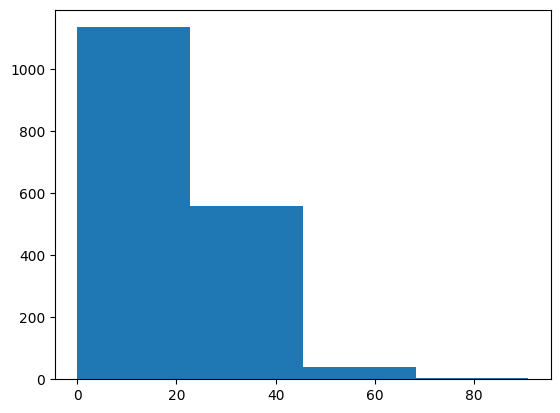

In [245]:
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen,bins=4)
plt.show()

In [246]:
## 정수 인코딩 및 패딩
import numpy as np
# 패딩까지 해주는 함수
def pad_sequences(sequences, max_length, pad_value):  
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length] 
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length   
        result.append(padded_sequence)
    return np.asarray(result)   

In [247]:
unk_id = token_to_id["<unk>"]   
train_ids = [[token_to_id.get(token, unk_id) for token in review] for review in train_tokens]  
test_ids = [[token_to_id.get(token, unk_id) for token in review] for review in test_tokens]

max_length = 30
pad_id = token_to_id["<pad>"]   
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

[3731  296  950  951  807 1747 2402  376  694 2403 1129 3732 3733  494
  807 1747 2402  406  551 3734 3735 3736  621  145 3737 3738 3739 3740
 3741  215]
[1688 1623   91   78  131  541 1316 1287 6526 1195   83   74    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [248]:
## 데이터로더
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.target.values, dtype=torch.float32)
test_labels = torch.tensor(test.target.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [249]:
for feature, label in train_loader:
    print(feature)
    print(label)
    break

tensor([[ 166,   24,  913, 4859, 1415, 4860,  109, 2145, 2030,  250, 1630, 3027,
           66,  640,  273, 2920,  142,  649,    7,   54,  188,  259,  112, 2145,
           71,  994, 1191,    6,  165, 2146],
        [ 539,  539, 5773,  539,   18,   57,   10,  410,  410,    5,  539,   18,
            5,  539,   18,    5,  539,   18,   13,   62,  539, 5774, 1092,  539,
          404, 1964,   10, 1805, 3368, 1579],
        [1346,  277,   10, 1507,  408,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 497, 2309, 2233,  450, 1650,  420, 2922,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 105,   86,  396, 1301, 5894, 3404, 2313,  377, 2313,   21,  341,  366,
           24,  476, 1941, 2313,  218, 1340, 2314, 1663,  545,    0,    0,    0,
      

In [250]:
# 문장 분류하는 모델
class SentenceClassifier(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers, n_classes ,dropout=0.5, bidirectional=True, model_type="lstm"):
        super().__init__()  # 부모클래스 상속

        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim, padding_idx=0)

        # rnn모델 일 경우
        if model_type == 'rnn':
            self.model = nn.RNN(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )
        # lstm모델 일 경우
        elif model_type == 'lstm':
            self.model = nn.LSTM(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )

        # bidirectional은 양방향성을 의미하는 파라미터
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, n_classes)   # 양방향일때 타임스탭에서 양방향의 정보(순방향,역방향)의 출력들을 결합하여 분류기에 전달
        else:
            self.classifier = nn.Linear(hidden_dim, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings) 
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [251]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [252]:
## 손실 함수와 최적화 함수 정의
from torch import optim
LR = 0.001
n_vocab = len(token_to_id)   # 단어사전의 크기
hidden_dim = 128     # 은닉 사태의 크기
embedding_dim = 128   #임베딩 벡터의 차원 128차원으로 사용
n_layers = 7     # 7층
n_classes = 1 # 2진 분류라 1

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers, n_classes=n_classes,model_type='rnn').to(device)
criterion = nn.BCEWithLogitsLoss().to(device)   
optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [253]:
# 모델 학습하는 함수
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%interval == 0:
            print(f'Train Loss {step} : {np.mean(losses)}')

In [254]:
# 모델 테스트하는 함수
def test1(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):   
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)  
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits)>.5  
        corrects.extend(torch.eq(yhat, labels).cpu().tolist())        

        val_loss = np.mean(losses)
        val_accuracy = np.mean(corrects)

    print(f"Val Loss : {val_loss}, Val Accuracy : {val_accuracy}")
    return val_loss


In [255]:
epochs = 20
interval = 500   

for epoch in range(epochs):
    print(f'epoch : {epoch}')
    train(classifier, train_loader, criterion, optimizer, device, interval)
    val_loss = test1(classifier, test_loader, criterion, device)
    scheduler.step(val_loss)

epoch : 0
Train Loss 0 : 0.704460859298706
Val Loss : 0.6579121557565836, Val Accuracy : 0.6010362694300518
epoch : 1
Train Loss 0 : 0.7220134139060974
Val Loss : 0.7043600540894729, Val Accuracy : 0.40414507772020725
epoch : 2
Train Loss 0 : 0.7646486759185791
Val Loss : 0.6839697957038879, Val Accuracy : 0.5906735751295337
epoch : 3
Train Loss 0 : 0.7086218595504761
Val Loss : 0.6668956554852999, Val Accuracy : 0.5906735751295337
epoch : 4
Train Loss 0 : 0.6878207325935364
Val Loss : 0.6683626266626211, Val Accuracy : 0.5751295336787565
epoch : 5
Train Loss 0 : 0.7045061588287354
Val Loss : 0.6648788108275487, Val Accuracy : 0.5699481865284974
epoch : 6
Train Loss 0 : 0.6697595119476318
Val Loss : 0.6792272833677439, Val Accuracy : 0.5544041450777202
epoch : 7
Train Loss 0 : 0.6596125960350037
Val Loss : 0.6741837996702927, Val Accuracy : 0.5699481865284974
epoch : 8
Train Loss 0 : 0.6901621222496033
Val Loss : 0.6716380898769085, Val Accuracy : 0.5906735751295337
epoch : 9
Train Los

In [256]:
torch.save(classifier.state_dict(), f'best_model3_state_dict().pth')

In [257]:
torch.save(classifier, f'best_model3.pth')

In [258]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model=torch.load('best_model3.pth', weights_only=False).to(device)

In [289]:
new_reviews = ["혼란의 도가니인 인생에 잘 모르겠는 것 투성이지만, 오늘도 그저 슬렁슬렁 살아가 본다.고양이들과 함께 창밖 구경, 꽃 구경을 하며 울고 웃고 먹고 마시는 방구석 인생.올해로 연재 20년차를 맞이하는, 낢의 미미하고 사소한 이야기."]

In [290]:
new_reviews = [re_text(review) for review in new_reviews]
new_tokens = [[token for token in tokenizer.nouns(review) if token not in stopwords] for review in new_reviews]
new_ids = [[token_to_id.get(token, unk_id) for token in tokens] for tokens in new_tokens]
new_ids_padded = pad_sequences(new_ids, max_length, pad_id)
new_ids_tensor = torch.tensor(new_ids_padded).to(device)

In [291]:
new_ids_padded

array([[ 257, 7411,   40, 2214,  216,  187,    1, 7473,  503, 7473,  478,
         185,  984,   40, 2373,  393, 1169,  331,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])

In [292]:
## 예측
model.eval()
with torch.no_grad():
    outputs = model(new_ids_tensor)
    predictions = torch.sigmoid(outputs)

# 9. 예측 결과 출력 (0.5 이상이면 긍정, 미만이면 부정)
for i, review in enumerate(new_reviews):
    prediction = predictions[i]
    prediction = 1 if predictions[i] >= 0.5 else 0
    print(f"리뷰: {review}")
    # print(prediction)
    print(f"예측된 결과: {'나이 제한 필요' if prediction == 1 else '전체 이용가'}")

리뷰: 혼란의 도가니인 인생에 잘 모르겠는 것 투성이지만  오늘도 그저 슬렁슬렁 살아가 본다 고양이들과 함께 창밖 구경  꽃 구경을 하며 울고 웃고 먹고 마시는 방구석 인생 올해로 연재  년차를 맞이하는  낢의 미미하고 사소한 이야기
예측된 결과: 전체 이용가


In [263]:
import pickle
# 단어 사전 저장
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.


In [264]:
import pickle

# 단어 사전 불러오기
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

print("단어 사전이 불러와졌습니다.")
print(vocab)

단어 사전이 불러와졌습니다.
['<pad>', '<unk>', '수', '시작', '이야기', '사람', '그녀', '날', '작가', '남자', '세상', '사랑', '내', '모든', '속', '살', '곳', '로맨스', '인간', '게임', '알', '다시', '전', '두', '학교', '위', '친구', '세계', '앞', '소녀', '소년', '주인공', '만화', '삶', '연애', '눈', '사건', '결혼', '비밀', '생활', '인생', '집', '판타지', '마음', '안', '일상', '뒤', '웹툰', '꿈', '신작', '말', '못', '줄', '운명', '정체', '더', '여자', '능력', '남', '온', '몸', '과거', '존재', '갑자기', '악마', '건', '최고', '이제', '귀신', '세', '현실', '죽음', '기억', '순간', '끝', '제안', '드라마', '가족', '중', '기', '복수', '향', '진짜', '액션', '선', '생각', '반', '고등학교', '사이', '사실', '최강', '고등학생', '게', '인기', '사고', '채', '남편', '위기', '밤', '싸움', '미래', '전설', '하루', '대한민국', '딸', '시절', '천재', '계약', '지금', '생', '점점', '소설', '준', '모습', '서로', '번', '힘', '외모', '적', '뭐', '목숨', '걸', '돈', '지옥', '만난', '지구', '차', '짝사랑', '손', '해', '거', '가장', '마을', '가지', '발견', '단편', '대한', '동생', '대학', '회사', '저주', '청춘', '관계', '처음', '작품', '왕', '단', '인류', '마주', '명', '본격', '선택', '살인', '빙의', '전쟁', '첫사랑', '정신', '황제', '마지막', '김', '기회', '피', '결심', '지상', '이름', '마법사', '마법', '등장', '통해', 

In [265]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 테스트하고 혼동 행렬을 시각화하는 함수
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()
    
    # 실제 레이블과 예측 값을 저장할 리스트
    all_labels = []
    all_predictions = []

    for step, (input_ids, labels) in enumerate(datasets):   
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)  
        loss = criterion(logits, labels)
        losses.append(loss.item())

        # 예측 값과 실제 값을 리스트에 추가
        yhat = torch.sigmoid(logits) > 0.5  
        all_labels.extend(labels.cpu().tolist())  # 실제 레이블
        all_predictions.extend(yhat.cpu().tolist())  # 예측 값

        corrects.extend(torch.eq(yhat, labels).cpu().tolist())

    val_loss = np.mean(losses)
    val_accuracy = np.mean(corrects)

    print(f"Val Loss : {val_loss}, Val Accuracy : {val_accuracy}")

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_predictions)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return val_loss

Val Loss : 0.6861485976439256, Val Accuracy : 0.5854922279792746


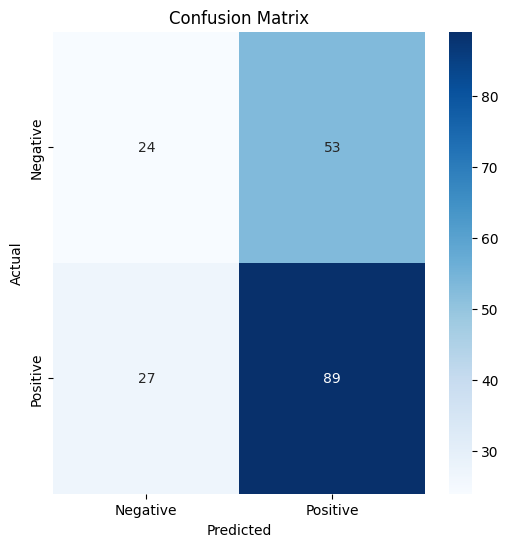

In [266]:
val_loss = test(classifier, test_loader, criterion, device)